In [1]:
%pip install numpy matplotlib pandas scikit-learn torch torchvision transformers

Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
from transformers import ViTFeatureExtractor, ViTModel
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

c:\Users\kyryl\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
batch_size = 4
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = trainset.classes

In [5]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [6]:
dataiter = iter(trainloader)
images, labels = next(dataiter)

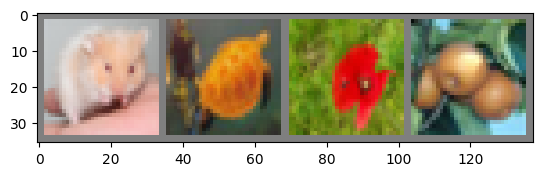

hamster turtle poppy  pear


In [7]:
imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

In [8]:
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')
model = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')

def extract_features(images):
    inputs = feature_extractor(images=list(images), return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).numpy()

batch_size_features = 32

def extract_all_features(dataset):
    all_features = []
    for i in range(0, len(dataset), batch_size_features):
        batch = dataset.data[i:i + batch_size_features]
        features = extract_features(batch)
        all_features.extend(features)
    return np.array(all_features)

def extract_all_features_sample(dataset, sample_size):
    all_features = []
    for i in range(0, min(len(dataset), sample_size), batch_size_features):
        batch = dataset.data[i:i + batch_size_features]
        features = extract_features(batch)
        all_features.extend(features)
    return np.array(all_features)

c:\Users\kyryl\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\models\vit\feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [9]:
sample_size_subset = 100
knn_raw = KNeighborsClassifier(n_neighbors=5)
knn_raw.fit(trainset.data.reshape(len(trainset), -1)[:sample_size_subset],
            np.array(trainset.targets[:sample_size_subset]))
predictions_raw = knn_raw.predict(testset.data.reshape(len(testset), -1)[:sample_size_subset])

print("Classification Report (k-NN on raw pixels - Subset):")
print(classification_report(np.array(testset.targets[:sample_size_subset]), predictions_raw))


Classification Report (k-NN on raw pixels - Subset):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         1
           6       0.05      0.50      0.09         2
           7       0.00      0.00      0.00         1
           8       0.00      0.00      0.00         2
           9       0.00      0.00      0.00         1
          10       0.00      0.00      0.00         1
          11       0.33      0.50      0.40         2
          13       0.00      0.00      0.00         1
          14       0.00      0.00      0.00         1
          15       0.00      0.00      0.00         2
          16       0.00      0.00      0.00         1
          17       0.00      0.00      0.00         1
          18       0.00      0.00      0.00         1
          20       0.00     

c:\Users\kyryl\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\kyryl\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\kyryl\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

In [10]:
sample_size_subset = 1000
train_features_subset = extract_all_features_sample(trainset, sample_size_subset)
train_labels_subset = np.array(trainset.targets[:len(train_features_subset)])
test_features_subset = extract_all_features_sample(testset, sample_size_subset)
test_labels_subset = np.array(testset.targets[:len(test_features_subset)])

knn_vit = KNeighborsClassifier(n_neighbors=5)
knn_vit.fit(train_features_subset, train_labels_subset)
predictions_vit_subset = knn_vit.predict(test_features_subset)

print("\nClassification Report (k-NN with ViT features - Subset):")
print(classification_report(test_labels_subset, predictions_vit_subset))


Classification Report (k-NN with ViT features - Subset):
              precision    recall  f1-score   support

           0       0.33      1.00      0.50         2
           2       0.00      0.00      0.00         1
           4       0.25      1.00      0.40         1
           6       0.11      1.00      0.19         2
           7       0.00      0.00      0.00         1
           8       0.60      1.00      0.75         3
           9       1.00      1.00      1.00         2
          10       0.00      0.00      0.00         2
          11       1.00      0.50      0.67         2
          13       0.00      0.00      0.00         1
          14       0.00      0.00      0.00         1
          15       1.00      1.00      1.00         2
          16       0.00      0.00      0.00         1
          17       0.67      1.00      0.80         2
          18       0.50      1.00      0.67         1
          19       1.00      1.00      1.00         1
          20       1.00

c:\Users\kyryl\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\kyryl\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")
c:\Users\kyryl\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\kyryl\AppData\Local

In [11]:
knn_raw = KNeighborsClassifier(n_neighbors=5)
knn_raw.fit(trainset.data.reshape(len(trainset), -1), np.array(trainset.targets))
predictions_raw = knn_raw.predict(testset.data.reshape(len(testset), -1))

print("\nClassification Report (k-NN on raw pixels - Full):")
print(classification_report(np.array(testset.targets), predictions_raw))


Classification Report (k-NN on raw pixels - Full):
              precision    recall  f1-score   support

           0       0.22      0.56      0.32       100
           1       0.14      0.20      0.16       100
           2       0.13      0.20      0.16       100
           3       0.07      0.11      0.09       100
           4       0.06      0.23      0.09       100
           5       0.07      0.08      0.07       100
           6       0.21      0.13      0.16       100
           7       0.07      0.19      0.10       100
           8       0.08      0.17      0.11       100
           9       0.12      0.31      0.17       100
          10       0.05      0.14      0.07       100
          11       0.24      0.12      0.16       100
          12       0.13      0.09      0.11       100
          13       0.00      0.00      0.00       100
          14       0.17      0.07      0.10       100
          15       0.08      0.09      0.08       100
          16       0.26      

In [12]:
train_features = extract_all_features(trainset)
test_features = extract_all_features(testset)

train_labels = np.array(trainset.targets)
test_labels = np.array(testset.targets)

knn_vit = KNeighborsClassifier(n_neighbors=5)
knn_vit.fit(train_features, train_labels)
predictions_vit = knn_vit.predict(test_features)

print("\nClassification Report (k-NN with ViT features - Full):")
print(classification_report(test_labels, predictions_vit))


Classification Report (k-NN with ViT features - Full):
              precision    recall  f1-score   support

           0       0.93      0.98      0.96       100
           1       0.91      0.96      0.93       100
           2       0.62      0.84      0.71       100
           3       0.76      0.84      0.80       100
           4       0.57      0.74      0.65       100
           5       0.82      0.93      0.87       100
           6       0.84      0.90      0.87       100
           7       0.80      0.78      0.79       100
           8       0.91      0.93      0.92       100
           9       0.86      0.89      0.88       100
          10       0.63      0.57      0.60       100
          11       0.51      0.57      0.54       100
          12       0.79      0.84      0.82       100
          13       0.88      0.75      0.81       100
          14       0.80      0.86      0.83       100
          15       0.82      0.88      0.85       100
          16       0.89  